# Starter Code

In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


################################ BEGIN NUMPY STARTER CODE #################################################
def sigmoid(x):
    #Numerically stable sigmoid function.
    #Taken from: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = np.exp(x)
        return z / (1 + z)


def sample_logistic_distribution(x,a):
    #np.random.seed(1)
    num_samples = len(x)
    y = np.empty(num_samples)
    for i in range(num_samples):
        y[i] = np.random.binomial(1,logistic_positive_prob(x[i],a))
    return y

def create_input_values(dim,num_samples):
    #np.random.seed(100)
    x_inputs = []
    for i in range(num_samples):
        x = 10*np.random.rand(dim)-5
        x_inputs.append(x)
    return x_inputs


def create_dataset():
    x= create_input_values(2,100)
    a=np.array([12,12])
    y=sample_logistic_distribution(x,a)

    return x,y

################################ END NUMPY STARTER CODE ####################################################



################################ BEGIN PYTORCH STARTER CODE ################################################

class TorchLogisticClassifier(nn.Module):

  def __init__(self, num_features):
    super().__init__()
    self.weights = nn.Parameter(torch.zeros(num_features))

  def forward(self, x_vector):
    logit = torch.dot(self.weights, x_vector)
    prob = torch.sigmoid(logit)
    return prob


def loss_fn(y_predicted, y_observed):
    return -1 * (y_observed * torch.log(y_predicted)
                 + (1 - y_observed) * torch.log(1 - y_predicted))

def extract_num_features(dataset):
    first_example = dataset[0]
    # first_example is a pair (x,y), where x is a vector of features and y is 0 or 1
    # note that both x and y are torch tensors
    first_example_x = first_example[0]
    first_example_y = first_example[1]
    num_features = first_example_x.size(0)
    return num_features

def nonbatched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01):
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(num_epochs):
        for d_x, d_y in dataset:
            optimizer.zero_grad()
            prediction = model(d_x)
            loss = loss_fn(prediction, d_y)
            loss.backward()
            optimizer.step()
    return model

def generate_nonbatched_data(num_features=3, num_examples=100):
    x_vectors = [torch.randn(num_features) for _ in range(num_examples)]
    prob_val = 0.5 * torch.ones(1)
    y_vectors = [torch.bernoulli(prob_val) for _ in range(num_examples)]

    dataset = list(zip(x_vectors, y_vectors))

    return dataset

def main():
    nonbatched_dataset = generate_nonbatched_data()
    nonbatched_gradient_descent(nonbatched_dataset)

################################ END PYTORCH STARTER CODE ###################################################


# NOTICE: DO NOT EDIT FUNCTION SIGNATURES 
# PLEASE FILL IN FREE RESPONSE AND CODE IN THE PROVIDED SPACES


# Problems 1 - 6

In [2]:
# PROBLEM 1
def logistic_positive_prob(x,a):
    z = np.dot(a, x)
    return sigmoid(z)

# PROBLEM 2
def logistic_derivative_per_datapoint(y_i,x_i,a,j):
    prob = logistic_positive_prob(x_i, a)
    return -(y_i - prob) * x_i[j]

# PROBLEM 3
def logistic_partial_derivative(y,x,a,j):
    n = len(y)
    partial_derivative = 0
    for i in range(n):
        partial_derivative += logistic_derivative_per_datapoint(y[i], x[i], a, j)
    return partial_derivative / n

# PROBLEM 4
def compute_logistic_gradient(a,y,x):
    k = len(a)
    gradient = np.zeros(k)
    for j in range(k):
        gradient[j] = logistic_partial_derivative(y, x, a, j)
    return gradient

# PROBLEM 5
def gradient_update(a,lr,gradient):
    return a - lr * gradient

# PROBLEM 6 (LUKE UPDATE)
def gradient_descent_logistic(initial_a, lr, num_iterations, y, x):
    a = initial_a
    for _ in range(num_iterations):
        gradient = compute_logistic_gradient(a, y, x)
        a = gradient_update(a, lr, gradient)
    return a


# Testing 1 - 6 

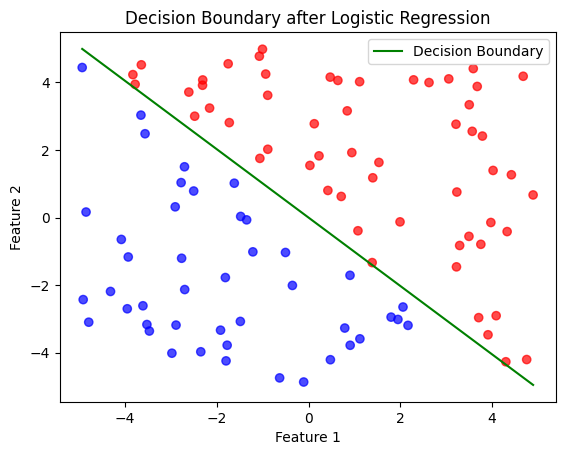

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_test_data():
    x, y = create_dataset()  # use the starter code to create dataset
    x = np.array(x)
    y = np.array(y)
    return x, y

def plot_decision_boundary(a, x, y):
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.7)
    x_boundary = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    y_boundary = -(a[0] / a[1]) * x_boundary
    plt.plot(x_boundary, y_boundary, color='green', label='Decision Boundary')
    plt.title('Decision Boundary after Logistic Regression')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Running a test
x, y = create_test_data()
initial_a = np.zeros(2)
lr = 0.01
num_iterations = 1000

final_a = gradient_descent_logistic(initial_a, lr, num_iterations, y, x)
plot_decision_boundary(final_a, x, y)

# Testing 9 

### Gloria Code

In [23]:
def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    batches = split_into_batches(dataset, batch_size)
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(num_epochs):         # epoch loop
        for batch in batches:           # batch loop
            # only call backward once per batch per epoch
            optimizer.zero_grad()
            for d_x, d_y in batch:      # loop inside batch
                prediction = model(d_x) 
                loss = loss_fn(prediction, d_y) 
                loss.backward()
            optimizer.step()
    return model

# PROBLEMS 10-12
def split_into_batches(dataset, batch_size):
    k_batches = len(dataset) / batch_size
    batches = []
    i = 0
    for k in range(int(k_batches)):
        batches.append(dataset[i:i+batch_size])
        i += batch_size
    return batches

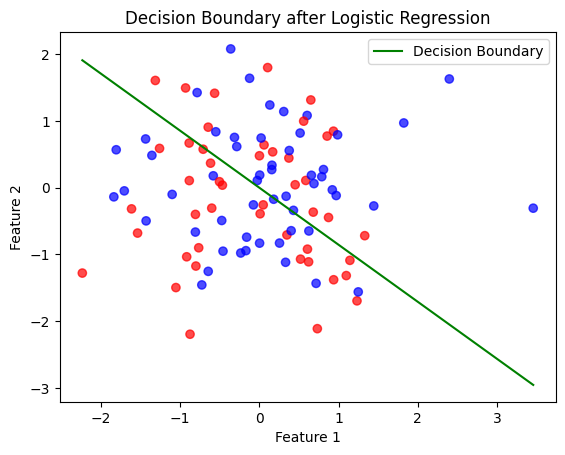

In [24]:
# test

def test_batched_gradient_descent():
    # Generate dataset
    dataset = generate_nonbatched_data(num_features=2, num_examples=100)
    
    # Run batched gradient descent
    model = batched_gradient_descent(dataset, num_epochs=50, learning_rate=0.01, batch_size=10)
    
    # Plot the decision boundary
    a = model.weights.detach().numpy()
    x = torch.stack([d[0] for d in dataset]).numpy()
    y = torch.stack([d[1] for d in dataset]).numpy()
    plot_decision_boundary(a, x, y)

test_batched_gradient_descent()

### Luke Code

In [21]:
def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        batches = split_into_batches(dataset, batch_size)
        for batch in batches:
            optimizer.zero_grad()
            batch_loss = 0
            for d_x, d_y in batch:
                prediction = model(d_x)
                loss = loss_fn(prediction, d_y)
                loss.backward()
                batch_loss += loss.item()
            optimizer.step()
    return model

# PROBLEMS 10-12
def split_into_batches(dataset, batch_size):
    return [dataset[i:i + batch_size] for i in range(0, len(dataset), batch_size)]

## Graph for 9

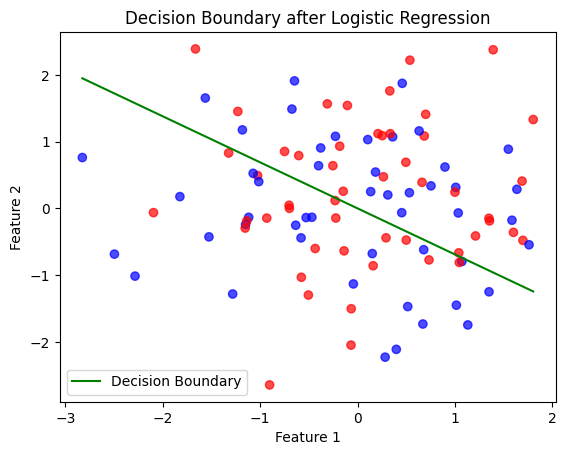

In [22]:
def test_batched_gradient_descent():
    # Generate dataset
    dataset = generate_nonbatched_data(num_features=2, num_examples=100)
    
    # Run batched gradient descent
    model = batched_gradient_descent(dataset, num_epochs=50, learning_rate=0.01, batch_size=10)
    
    # Plot the decision boundary
    a = model.weights.detach().numpy()
    x = torch.stack([d[0] for d in dataset]).numpy()
    y = torch.stack([d[1] for d in dataset]).numpy()
    plot_decision_boundary(a, x, y)

test_batched_gradient_descent()